<a href="https://colab.research.google.com/github/astroarth/AI_use_cases/blob/main/AI_Finance_%7C_v2_Fraud_detection_%7C_Autoencoder%2C_XGBoost%2C_LightGBM%2C_CatBoost%2C_Random_Forest%2C_LogReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.2 MB/s eta 0:00:00


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
 82% 54.0M/66.0M [00:00<00:00, 189MB/s]
100% 66.0M/66.0M [00:00<00:00, 190MB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [ ]:
# Load dataset
# Dataset consists of financial transaction data where 'Class' indicates whether the transaction is fraudulent (1) or not (0).
df = pd.read_csv("creditcard.csv")


In [ ]:
# Data exploration
print("Dataset preview:")
print(df.head())  # Check the first few rows to confirm structure: features like Time, Amount, and Class (fraud or not)
print("Missing values:")
print(df.isnull().sum())  # Ensure no missing values, as missing data can introduce bias or instability in model performance
print("Class distribution:")
print(df['Class'].value_counts())  # Inspect the class imbalance. Fraudulent transactions (1) are significantly rarer.


Dataset preview:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26    

In [ ]:


# Data Preprocessing
scaler = StandardScaler()
df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])
# Feature scaling via StandardScaler standardizes all features to have zero mean and unit variance.
# This is especially important for gradient-based methods (e.g., XGBoost, neural networks) that are sensitive to feature scaling.
# If the features were not standardized, certain features with larger scales (like 'Amount' or 'Time') could dominate, leading to biased parameter updates during model training.

# Split data into features (X) and labels (y)
X = df.drop(columns=['Class']).values  # X contains all feature columns except 'Class'
y = df['Class'].values  # y is the target variable (Class), which indicates fraud (1) or not (0)

# Addressing Class Imbalance with SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(sampling_strategy=0.1, random_state=42)
# SMOTE works by creating synthetic examples for the minority class (fraud). It oversamples the minority class by generating synthetic examples
# in the feature space, using the k-nearest neighbors of each minority class sample. The `sampling_strategy=0.1` means that after oversampling,
# the minority class (fraud) will make up 10% of the majority class (non-fraud).
# This ensures the model is exposed to enough fraud examples, avoiding bias toward the majority class, without overfitting.
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
# Stratified splitting ensures that the class distribution in both the training and test sets reflects that of the original dataset.
# This is important, especially for imbalanced datasets, as it ensures that the test set contains a similar proportion of fraud and non-fraud samples,
# preventing performance evaluation bias due to an unrepresentative test set.


# Model Architectures

# XGBoost (Extreme Gradient Boosting)

In [ ]:
# XGBoost (Extreme Gradient Boosting)
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # Use binary logistic regression for classification
    eval_metric='logloss',  # Log loss is used as an evaluation metric to quantify prediction error.
    n_estimators=500,  # Number of boosting rounds, or trees. Higher values increase model complexity.
    learning_rate=0.05,  # Learning rate (shrinkage), controlling the contribution of each tree. A lower rate slows learning.
    max_depth=6,  # The depth of each tree. Shallow trees help to prevent overfitting, deeper trees can capture more complex relationships.
    subsample=0.8,  # Fraction of samples to use for building each tree. Reduces overfitting by introducing randomness.
    colsample_bytree=0.8,  # Fraction of features used per tree. Prevents overfitting by promoting feature randomness.
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)  # Adjusts for class imbalance by weighting the minority class.
)
# XGBoost is a high-performance, gradient boosting algorithm that builds trees sequentially, where each tree corrects the errors of the previous ones.
# It implements parallelized tree construction and includes regularization terms (L1 and L2) that reduce model complexity and overfitting.
# The 'scale_pos_weight' parameter is crucial for handling class imbalance, as it weights the loss function to give more importance to fraud cases during training.


# LightGBM (Light Gradient Boosting Machine)


In [ ]:

# LightGBM (Light Gradient Boosting Machine)
lgb_model = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, class_weight='balanced')
# LightGBM is another gradient boosting framework designed for speed and scalability. It uses a histogram-based approach to discretize continuous features,
# speeding up the training process by reducing the complexity of the tree building.
# The leaf-wise growth strategy, as opposed to level-wise, allows LightGBM to capture deeper structures but may risk overfitting if not tuned.
# The 'class_weight=balanced' automatically adjusts the weights of the minority class to account for class imbalance.


# CatBoost (Categorical Boosting)


In [ ]:

# CatBoost (Categorical Boosting)
cb_model = cb.CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, verbose=0, scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train))
# CatBoost is a gradient boosting algorithm developed to handle categorical features more efficiently.
# It employs ordered boosting, a technique designed to avoid target leakage during training. CatBoost uses symmetric trees to reduce prediction time by optimizing CPU cache usage.
# Similar to XGBoost and LightGBM, 'scale_pos_weight' is used to handle the class imbalance by adjusting the loss function.


# Random Forest

In [ ]:

# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
# Random Forest is an ensemble method that builds multiple decision trees by bootstrapping (random sampling with replacement) the training set and using random subsets of features for each tree.
# This reduces variance and overfitting by averaging predictions over many trees. The 'class_weight=balanced' ensures that the minority class (fraud) is given more importance during model training.


# Logistic Regression


In [ ]:

# Logistic Regression
lr_model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
# Logistic Regression is a simple yet effective linear classifier. It’s used here to baseline performance with a less complex model.
# L2 regularization (Ridge) is applied by default to prevent overfitting, especially when dealing with imbalanced data. The 'liblinear' solver is optimal for small to medium datasets.


# Autoencoder Anomaly Detection


In [ ]:

# Autoencoder Anomaly Detection
input_dim = X_train.shape[1]  # Number of input features in the dataset
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)  # Bottleneck layer reduces dimensionality (from 30 features down to 16, then to 8, then 4)
decoded = Dense(input_dim, activation='sigmoid')(encoded)  # Reconstruction layer outputs the same shape as input
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')  # Mean Squared Error (MSE) loss function, which compares the original input and the reconstructed output
autoencoder.fit(X_train, X_train, epochs=20, batch_size=256, shuffle=True, validation_data=(X_test, X_test), verbose=1)
# Autoencoders are unsupervised models that learn to compress data (dimensionality reduction) and then reconstruct it.
# The assumption is that normal transactions will have low reconstruction errors, whereas fraudulent transactions (anomalies) will deviate significantly, resulting in higher reconstruction errors.
# By training on the normal data, the autoencoder learns to capture the typical distribution, and anomalies are identified based on how poorly they are reconstructed.


Epoch 1/20
978/978 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.8521 - val_loss: 2.6231
Epoch 2/20
978/978 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 2.6269 - val_loss: 2.5715
Epoch 3/20
978/978 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 2.5843 - val_loss: 2.5543
Epoch 4/20
978/978 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 2.5590 - val_loss: 2.5432
Epoch 5/20
978/978 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 2.5443 - val_loss: 2.5345
Epoch 6/20
978/978 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.5282 - val_loss: 2.5298
Epoch 7/20
978/978 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 2.5700 - val_loss: 2.5266
Epoch 8/20
978/978 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.5192 - val_loss: 2.5232
Epoch 9/20
978/978 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.5561 - val_loss: 2.5214
Epoch 10/20
978/978 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 2.5031 - val_loss: 2.5201
Epoch 11/20
978/978 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 2.4885 - val_loss: 2.5188
Epoch 12/20
978/978 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/ste

In [ ]:
# Train all models before evaluating
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
cb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 22745, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 250196, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

# Model Evaluation Protocol


In [ ]:
def evaluate_model(model, name):
    y_pred = model.predict(X_test)  # Predict the labels (fraud or not fraud) for the test data
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred  # For models like XGBoost that return probabilities, select the probability for class 1 (fraud)
    print(f"\n{name} Model Performance:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))  # The classification report provides precision, recall, f1-score, and support (number of true samples) for each class.
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))  # Confusion matrix allows us to see true positives, false positives, true negatives, and false negatives.
    print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))  # ROC-AUC measures the model's ability to distinguish between the classes, especially in the presence of imbalanced data.
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)  # Precision-Recall curve focuses on the performance of the model for the minority class.
    pr_auc = auc(recall, precision)  # Compute the Area Under the Precision-Recall Curve (PR AUC) which is crucial in imbalanced class settings.
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'{name} PR AUC = {pr_auc:.2f}')  # Plot the Precision-Recall curve
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name} Precision-Recall Curve')
    plt.legend()
    plt.show()

# Run evaluations on all models



XGBoost Model Performance:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      1.00      1.00      5686

    accuracy                           1.00     62550
   macro avg       1.00      1.00      1.00     62550
weighted avg       1.00      1.00      1.00     62550

Confusion Matrix:
[[56828    36]
 [    1  5685]]
ROC-AUC Score: 0.9999923019516387


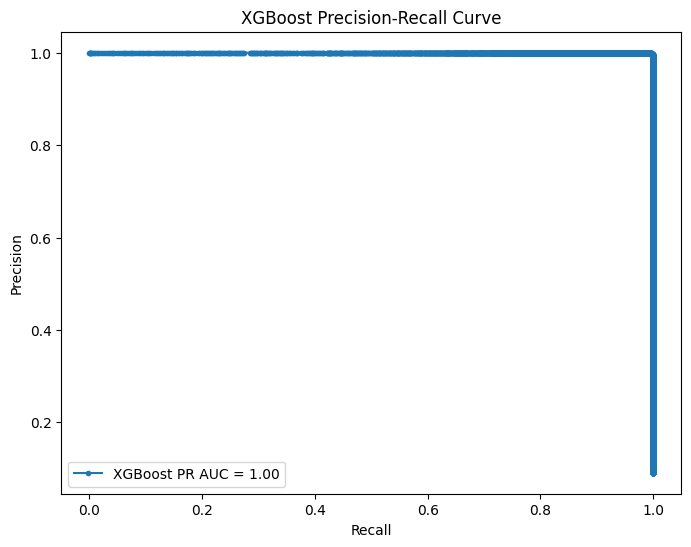

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



LightGBM Model Performance:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      1.00      1.00      5686

    accuracy                           1.00     62550
   macro avg       1.00      1.00      1.00     62550
weighted avg       1.00      1.00      1.00     62550

Confusion Matrix:
[[56828    36]
 [    2  5684]]
ROC-AUC Score: 0.9999873224989019


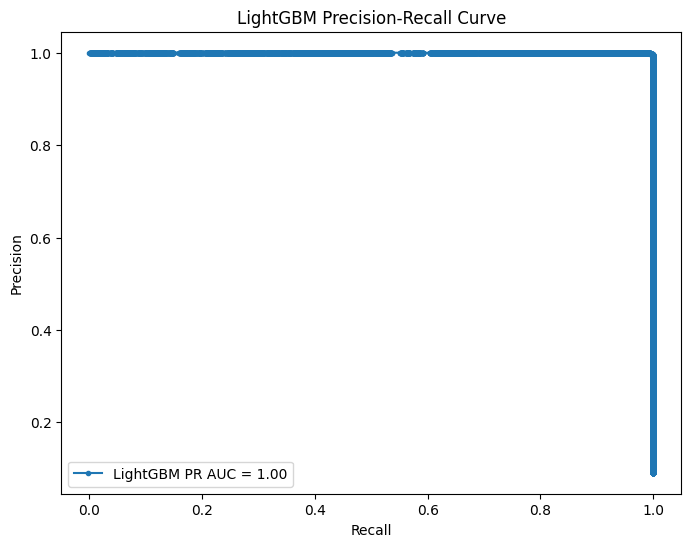


CatBoost Model Performance:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      1.00      0.99      5686

    accuracy                           1.00     62550
   macro avg       0.99      1.00      1.00     62550
weighted avg       1.00      1.00      1.00     62550

Confusion Matrix:
[[56784    80]
 [    1  5685]]
ROC-AUC Score: 0.999962369564318


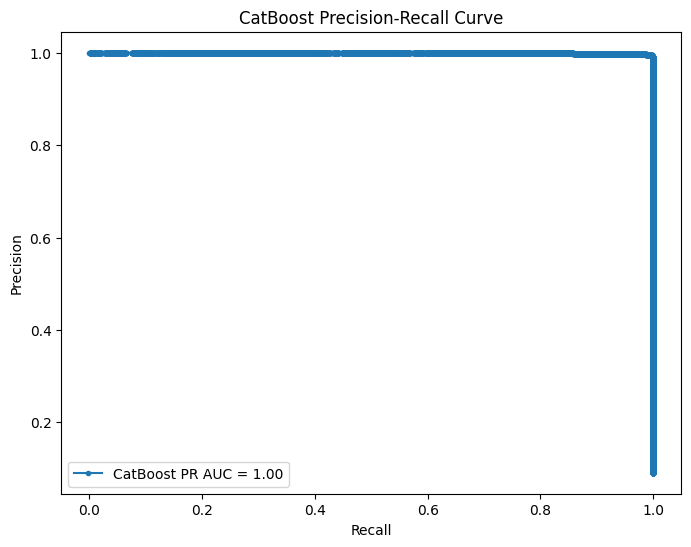


Random Forest Model Performance:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       1.00      0.99      1.00      5686

    accuracy                           1.00     62550
   macro avg       1.00      1.00      1.00     62550
weighted avg       1.00      1.00      1.00     62550

Confusion Matrix:
[[56852    12]
 [   39  5647]]
ROC-AUC Score: 0.9999912936897801


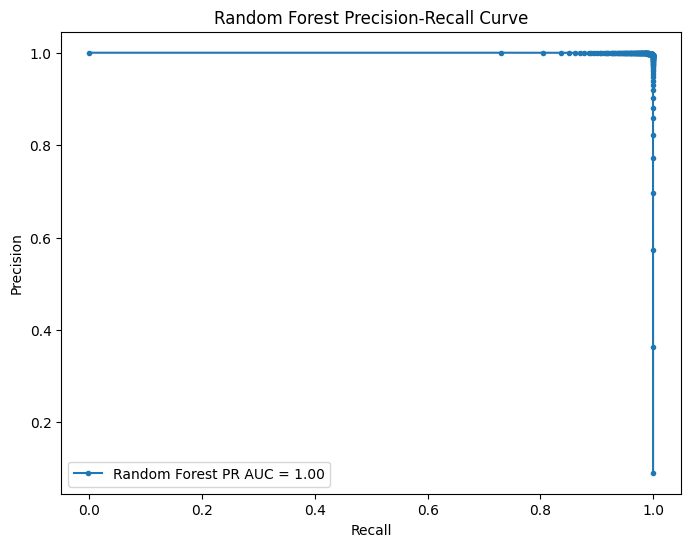


Logistic Regression Model Performance:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     56864
           1       0.79      0.93      0.85      5686

    accuracy                           0.97     62550
   macro avg       0.89      0.95      0.92     62550
weighted avg       0.97      0.97      0.97     62550

Confusion Matrix:
[[55452  1412]
 [  425  5261]]
ROC-AUC Score: 0.9901223972369616


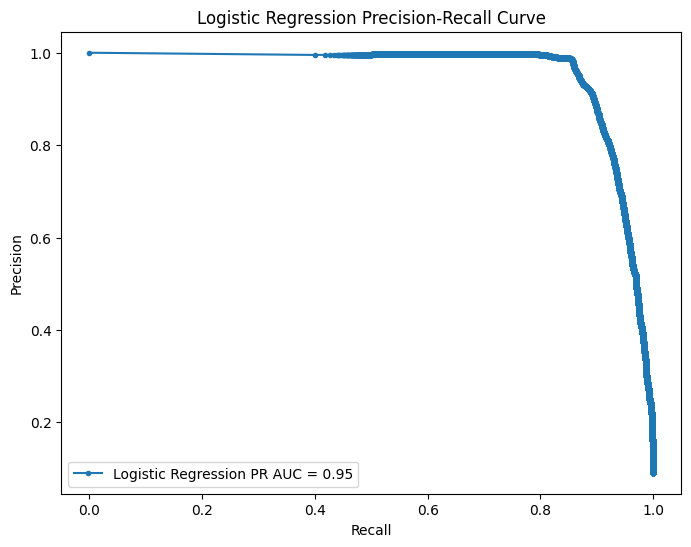

In [ ]:


evaluate_model(xgb_model, "XGBoost")
evaluate_model(lgb_model, "LightGBM")
evaluate_model(cb_model, "CatBoost")
evaluate_model(rf_model, "Random Forest")
evaluate_model(lr_model, "Logistic Regression")
